# Fitting the Sorption Profile of CO2 in Polyol to Predict Equilibrium

## Introduction

Because the diffusion of a gas into a liquid never truly reaches equilibrium, the G-ADSA method developed by Prof. Ernesto Di Maio must necessarily terminate measurement of the change in mass due to solvation of CO2 in the polymer before equilibrium is reached. To calculate the true equilibrium value, extrapolation is required (otherwise the results will suffer from a systematic underestimation of the solubility). This file intends to identify a satisfactory mathematical fit to the mass increase over time to extrapolate the equilibrium mass.

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import time
from scipy.optimize import curve_fit

import dataproc

from importlib import reload
reload(dataproc)

# Set user parameters
data_folder = '../../EXPERIMENTS/Italy/data/adsa/'
data_file = 'v2110b-TRD-061219-1804.csv'
pressure_steps = [0, 50, 150, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500] # user-defined set points [kPa]
p_thresh_frac = 0.02 # threshold for acceptable difference between actual pressure and set pressure [fraction]
m_thresh = 0.00003 # threshold for mass to be considered stable [g]
is_mp1 = 2 # number indicating that the balance is in the position for "measuring point 1" (crucible, hook, sample)

## Load Data

In [132]:
df_full = pd.read_csv(data_folder + data_file, header=3)
# remove data from before vacuum is reached
vacuum_reached = np.where(df_full['Now Pressure(kPa)'].values==0)[0][0]
df = df_full.iloc[vacuum_reached:]
df.head()

,No.,DATE,TIME,TEMP4_PV,TEMP4_SV,Julabo_Ext_PV,Julabo_Int_PV,Julabo_SV,BALANCE POSITION,WEITGHT(g),...,V17,V18,V19,V20,TMP_START,P5_HV,C_PUMP,C1,C2,Julabo_CTRL
64,65,06-12-2019,18:37:28,26.7,0.0,28.1,39.9,30.0,2.0,7.96887,...,1,1,0,0,1,1,0,0,0,Ext_CTRL
65,66,06-12-2019,18:37:58,26.7,0.0,28.1,39.9,30.0,2.0,7.96887,...,1,1,0,0,1,1,0,0,0,Ext_CTRL
66,67,06-12-2019,18:38:28,26.7,0.0,28.1,39.9,30.0,2.0,7.96885,...,1,1,0,0,1,1,0,0,0,Ext_CTRL
67,68,06-12-2019,18:38:58,26.4,0.0,28.1,39.9,30.0,2.0,7.96885,...,1,1,0,0,1,1,0,0,0,Int-CTRL
68,69,06-12-2019,18:39:28,26.7,0.0,28.1,39.9,41.5,2.0,7.96884,...,1,1,0,0,1,1,0,0,0,Int-CTRL


## Extract Data For Plotting

In [133]:
# Extract time in terms of seconds after start
date_raw = df['DATE']
time_raw = df['TIME']
t_arr = dataproc.convert_time(date_raw, time_raw)

# Extract balance reading and position (to separate zero, measuring point 1, and measuring point 2)
br_arr = df['WEITGHT(g)']
bp_arr = df['BALANCE POSITION']

# Extract the pressure
p_arr = df['Now Pressure(kPa)']

# Label the sections of the experiment by pressure steps (0 is preparation phase in vacuum)
data_dict = {}

for i in range(len(pressure_steps)):
    p = pressure_steps[i]
    inds_curr = np.logical_and(np.abs(p_arr - p) < p_thresh_frac*p, bp_arr == is_mp1)
    data_dict[p] = {}
    data_dict[p]['balance reading [g]'] = br_arr.values[inds_curr]
    data_dict[p]['time [s]'] = t_arr[inds_curr]

## Exploratory Data Analysis

For simplicity, we will start by exploring the mass for the first pressure increase, when the pressure is set to 50 kPa.

Text(0.5,1,'Mass over time at 150 kPa')

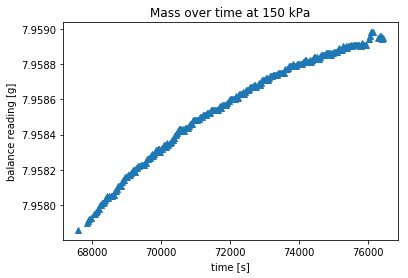

In [134]:
# extract mass and time
p = 150 # pressure [kPa]
m_150_arr = data_dict[p]['balance reading [g]']
t_150_arr = data_dict[p]['time [s]']

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t_150_arr, m_150_arr, '^')
ax.set_xlabel('time [s]')
ax.set_ylabel('balance reading [g]')
ax.set_title('Mass over time at {p} kPa'.format(p=p))

The plot does not seem to plateau at the end as hoped. This is not a huge problem because we will probably not use this measurement for fitting Huikuan's model.

To determine the fit, I will now plot on semilog and loglog plots. This will be easier by plotting relative to the first point (meaning set the first point to 0 time and pressure).

Text(0.5,1,'Mass over time at 150 kPa')

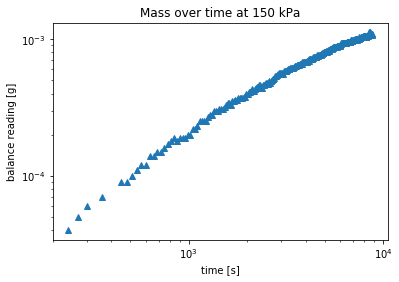

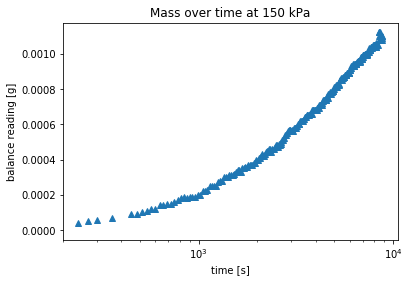

In [135]:
# Zero data
m_150_arr_0 = m_150_arr - m_150_arr[0]
t_150_arr_0 = t_150_arr - t_150_arr[0]

# Plot loglog
fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(t_150_arr_0, m_150_arr_0, '^')
ax.set_xlabel('time [s]')
ax.set_ylabel('balance reading [g]')
ax.set_title('Mass over time at {p} kPa'.format(p=p))

# Plot semilogx
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(t_150_arr_0, m_150_arr_0, '^')
ax.set_xlabel('time [s]')
ax.set_ylabel('balance reading [g]')
ax.set_title('Mass over time at {p} kPa'.format(p=p))

The loglog plot is more linear overall, but the semilogx plot is more linear at the end. However, now that I think about it, neither of these represents a trend that will approach a horizontal asymptote (the true equilibrium balance reading). Therefore, I will instead try to fit that data to specific functional forms that approach an asymptote.

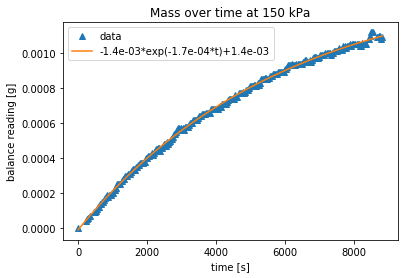

In [136]:
# Define functional forms to fit

def exponential_approach(x, a, b, c):
    """Exponential approach to asymptote. Negatives and /100 there because I can't figure out how to change the initial
    parameters for the curve_fit function from all 1's."""
    return -a*np.exp(-b/100*x) + c

def power_law_approach(x, a, b, c):
    """Power-law approach to asymptote."""
    return -a*x**(-b/100) + c

# Perform exponential fit
popt_exp, pcov_exp = curve_fit(exponential_approach, t_150_arr_0, m_150_arr_0)
a_exp, b_exp, c_exp = popt_exp
t_150_fit = np.linspace(0, t_150_arr_0[-1], 100)
m_150_exp_fit = exponential_approach(t_150_fit, a_exp, b_exp, c_exp)
# Plot exponential fit
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t_150_arr_0, m_150_arr_0, '^', label='data')
ax.plot(t_150_fit, m_150_exp_fit, label='{:.1e}*exp({:.1e}*t)+{:.1e}'.format(-a_exp, -b_exp/100, c_exp))
ax.set_xlabel('time [s]')
ax.set_ylabel('balance reading [g]')
ax.set_title('Mass over time at {p} kPa'.format(p=p))
plt.legend(loc='best')

# # Perform power-law fit
# popt_pwr, pcov_pwr = curve_fit(power_law_approach, t_50_arr_0[1:], m_50_arr_0[1:])
# a_pwr, b_pwr, c_pwr = popt_pwr
# m_50_pwr_fit = power_law_approach(t_50_fit[1:], a_exp, b_exp, c_exp)
# # Plot exponential fit
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(t_50_arr_0, m_50_arr_0, '^', label='data')
# ax.plot(t_50_fit, m_50_pwr_fit, label='{:.1e}*exp({:.1e}*t)+{:.1e}'.format(-a_pwr, -b_pwr/100, c_pwr))
# ax.set_xlabel('time [s]')
# ax.set_ylabel('balance reading [g]')
# ax.set_title('Mass over time at {p} kPa'.format(p=p))
# plt.legend(loc='best')

Looks like the exponential fit works well and the power-law fit fails, so I will use an exponential fit.

## When to move to the next pressure step?

To determine this, I must find the time after which additional data points no longer changes the prediction for the asymptotic equilibrium value. I will repeat this process for all of the pressure steps for which the pressure increases by 500 kPa since the time to reach equilibrium will be longest for these and these are the data points in which I am most interested.

In [138]:
# pressures to consider [kPa]
p_test = [1000, 1500, 2000, 2500, 3000]
# initialize data structure to store stability times (time in which mass must be stable to move to next pressure step)
stability_time_arr = np.zeros([len(p_test)])
# time step between times to test for equilibrium
dt = 30

# Find the stability time for each pressure
for i in range(len(p_test)):
    # extract mass and time
    p = p_test[i] # pressure [kPa]
    print("p = " + str(p))
    m_arr = data_dict[p]['balance reading [g]']
    t_arr = data_dict[p]['time [s]']
    # zero mass and time
    m_arr -= m_arr[0]
    t_arr -= t_arr[0]
    # find latest time needed to predict equilibrium point
    m_eq_true = dataproc.extrapolate_equilibrium(t_arr, m_arr)
    # cut final time
    t_cut = dt
    t_f = t_arr[-1]
    inds_cut = t_arr < t_f - t_cut
    m_eq_est = dataproc.extrapolate_equilibrium(t_arr[inds_cut], m_arr[inds_cut])
    while np.abs(m_eq_est - m_eq_true) < m_thresh:
        t_cut += dt
        inds_cut = t_arr < t_arr[-1] - t_cut
        m_eq_est = dataproc.extrapolate_equilibrium(t_arr[inds_cut], m_arr[inds_cut])
    print("t_cut " + str(t_cut))
    # cut the time to the last required data point to get an accurate extrapolation for the equilibrium mass
    inds_suff = t_f-t_arr >= t_cut
    t_suff_arr = t_arr[inds_suff]
    m_suff_arr = m_arr[inds_suff]
    unstable_mass = np.abs(m_suff_arr[-1] - m_suff_arr) > m_thresh
    ind_last_unstable_mass = np.where(unstable_mass)[0][-1]
    ind_first_stable_mass = ind_last_unstable_mass + 1
    print("m_suff final")
    print(m_suff_arr[-10:])
    t_stab = t_suff_arr[-1] - t_suff_arr[ind_first_stable_mass]
    print("t_stab = {t_stab} s".format(t_stab=t_stab))
    # save stability time
    stability_time_arr[i] = t_stab
    
# print results for stability time
print(stability_time_arr)

p = 1000
t_cut 1260
m_suff final
[0.00992 0.00992 0.00993 0.00993 0.00993 0.00993 0.00994 0.00994 0.00994
 0.00995]
t_stab = 210 s
p = 1500
t_cut 1320
m_suff final
[0.01209 0.01209 0.01209 0.01209 0.01209 0.01209 0.01209 0.01209 0.01209
 0.0121 ]
t_stab = 600 s
p = 2000
t_cut 990
m_suff final
[0.01295 0.01295 0.01295 0.01295 0.01295 0.01296 0.01296 0.01296 0.01297
 0.01297]
t_stab = 330 s
p = 2500
t_cut 30
m_suff final
[0.01381 0.01381 0.01381 0.01649 0.01376 0.01378 0.01377 0.01376 0.01378
 0.0138 ]
t_stab = 30 s
p = 3000
t_cut 1680
m_suff final
[0.01485 0.01487 0.01487 0.01486 0.01484 0.01483 0.01485 0.01487 0.01486
 0.01486]
t_stab = 360 s
[210. 600. 330.  30. 360.]


It seems like the stability time varies substantially, but that 300 s is pretty good. This will ensure that the uncertainty in the equilibrium value is within about 30 ug, which is about 3% of the total change in mass from one pressure step to the next (500 kPa).